# Introduction to ADCP Data Analysis

This Jupyter Notebook provides a comprehensive guide to analyzing Acoustic Doppler Current Profiler (ADCP) data, a critical dataset used in oceanography and hydrology to measure water current velocities over a range of depths. ADCPs are deployed to monitor various water column parameters, including current direction, speed, temperature, and pressure, across both time and depth. By analyzing this dataset, we can gain insights into water movement patterns, understand environmental conditions, and assess temporal changes in aquatic environments.

## Notebook Outline

This notebook is organized into two main sections:

### 1. Data Loading and Cleaning

- We begin by loading the raw ADCP dataset and exploring its structure, including time, range (depth), and any directional components (e.g., east, north, up).
- The data cleaning process involves handling missing values, ensuring consistent coordinate systems, and verifying the quality of each data variable to ensure accurate analysis.

### 2. Data Visualisation

- Once the dataset is prepared, we proceed with visualisation to uncover patterns and trends. Key visualisations include:
  - **Time series plots** of velocity components and environmental variables, such as temperature and pressure.
  - **Depth profiles and heatmaps** to observe variations across depth and time.
  - **Quiver plots** to depict current direction and magnitude at different time intervals.

### 3. Set up Data for Wave Analysis

- We need to prepare the ADCP data for wave analysis
  - A pandas dataframe to be analysed in other notebooks



These visualisations help us interpret the spatial and temporal dynamics of water currents and related variables within the dataset.

Through this notebook, you will gain a deeper understanding of the ADCP dataset and learn valuable techniques for its analysis and visualisation.



### **Acoustic Doppler Current Profiler (ADCP)** 
**A tool used in coastal marine science to measure water current velocities across a depth range, essential for coral reef studies.**
- **Operating Principle**: Emits sound waves and measures Doppler shift upon reflection from particles in the water, allowing for current velocity profiling.
- **Data Collected**:
  - Vertical profiles of **current velocity** and **direction**
  - **Wave height** and **wave period**
- **Data Processing**:
  - Correct for **tidal influences**
  - **Filter noise** and average data over time or depth bins for clearer patterns
- **Applications**: Helps in understanding water flow, sediment transport, and hydrodynamic forces impacting reef health, including nutrient dispersion and physical stress on coral structures.

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as dt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
import dolfyn
from dolfyn.adp import api

## Step 1: Load the data

### Xarray datasets

An **xarray Dataset** is a multi-dimensional, labeled data structure, ideal for organizing complex scientific data. <br/>
It supports efficient data manipulation and analysis, including indexing by dimension names and handling missing data. <br/>
xarray also integrates well with other scientific libraries like NumPy and Dask for large-scale computations.<br/>
read more here: https://docs.xarray.dev/en/stable/

In [4]:
ds = dolfyn.load('data/20231112_north_groove_adcp_processed.nc')
ds_avg = dolfyn.load('data/20231112_north_groove_adcp_processed_averaged.nc')

What does the data look like?

In [384]:
ds

<xarray.Dataset>
Dimensions:              (time: 993252, dirIMU: 3, dir: 4, range: 44, beam: 4,
                          time_b5: 993252, range_b5: 44, x: 4, x*: 4, earth: 3,
                          inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 2023-11-23T08:00:00.125999 ......
  * dirIMU               (dirIMU) object 'E' 'N' 'U'
  * dir                  (dir) object 'E' 'N' 'U1' 'U2'
  * range                (range) float64 0.7 0.9 1.1 1.3 1.5 ... 8.7 8.9 9.1 9.3
  * beam                 (beam) int32 1 2 3 4
  * time_b5              (time_b5) datetime64[ns] 2023-11-23T08:00:00.063199 ...
  * range_b5             (range_b5) float64 0.7 0.9 1.1 1.3 ... 8.7 8.9 9.1 9.3
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
  * earth                (earth) object 'E' 'N' 'U'
  * inst                 (inst) object 'X' 'Y' 'Z'
Data variables: (12/41)
    c_sound              (time) float32 1.533e+03 1.533e+03 ... 1.533e+03
    temp                 (time) float32 24.45 24.45 24.45 ... 24.29 24.29 24.29
    pressure             (time) float32 7.552 7.566 7.58 ... 7.066 7.073 7.073
    mag                  (dirIMU, time) float64 -7.998 -7.998 ... 38.41 38.41
    accel                (dirIMU, time) float64 0.001022 0.001022 ... 9.785
    batt                 (time) float32 13.6 13.6 13.6 13.6 ... 11.4 11.4 11.4
    ...                   ...
    pitch                (time) float32 -0.58 -0.58 -0.58 ... -0.61 -0.61 -0.61
    roll                 (time) float32 8.78 8.78 8.78 8.78 ... 8.81 8.81 8.81
    beam2inst_orientmat  (x, x*) float32 1.183 0.0 -1.183 ... 0.5518 0.0 0.5518
    orientmat            (earth, inst, time) float64 0.5104 0.5104 ... 0.9881
    water_density        (time) float32 1.02e+03 1.02e+03 ... 1.021e+03
    depth                (time) float32 7.944 7.958 7.972 ... 7.457 7.464 7.465
Attributes: (12/47)
    inst_model:                Signature1000
    inst_make:                 Nortek
    inst_type:                 ADCP
    rotate_vars:               ['vel', 'accel', 'accel_b5', 'mag', 'mag_b5']
    n_cells:                   44
    n_beams:                   4
    ...                        ...
    coord_sys:                 earth
    has_imu:                   0
    fs:                        4
    h_deploy:                  0.4
    declination:               -9.7
    declination_in_orientmat:  1

## Data cleaning

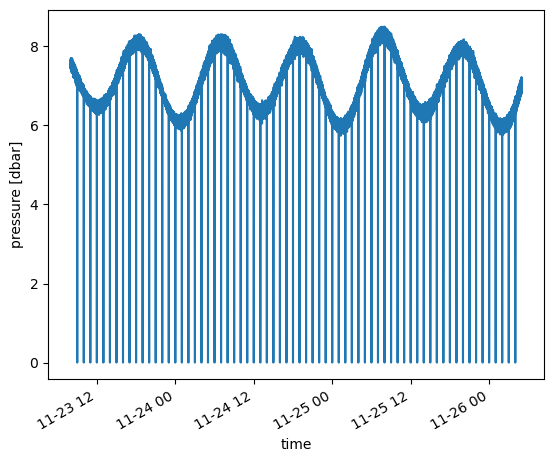

In [179]:
ds['pressure'].plot()

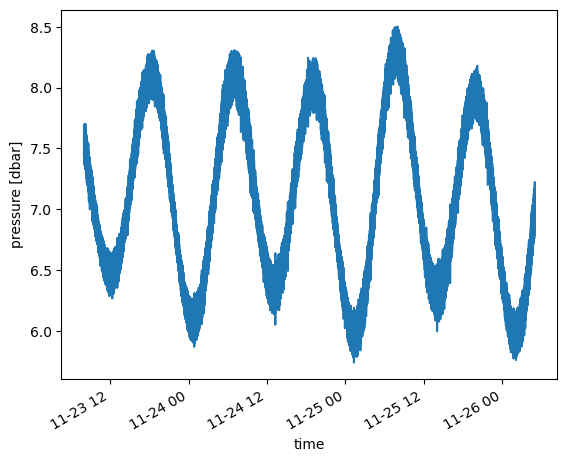

In [189]:
#remove NaN or 0 values:
ds['pressure'] = ds['pressure'].where(ds['pressure'] != 0)

#Check the data is looking better:
ds['pressure'].plot()

# This is also required for depth:
ds['depth'] = ds['depth'].where(ds['depth'] !=0.4000000059604645)
#Here, the NaN value for depth is near 0.4

Find the start and end times of the datasets:

In [192]:
print(f'Start time: ',ds.time.min().values)
print('End time: ', ds.time.max().values)


Start time:  2023-11-23T08:00:00.125999000
End time:  2023-11-26T04:57:58.875999000


# Step 2: Data visulisation

1. A new figure is created with specific dimensions and axis configuration.
2. `t` converts the time data from the ADCP dataset to date format.
3. A color-mesh plot (`pcolormesh`) is generated for flow speed (`U_mag`), using a 'viridis' color map and a velocity range of 0 to 0.1 m/s.
4. The surface depth is overlaid on the plot using `ax.plot`.
5. The x-axis is labeled with time, formatted as hours and minutes.
6. The y-axis shows altitude, limited to 0–12 meters, and a color bar indicates horizontal velocity in m/s.

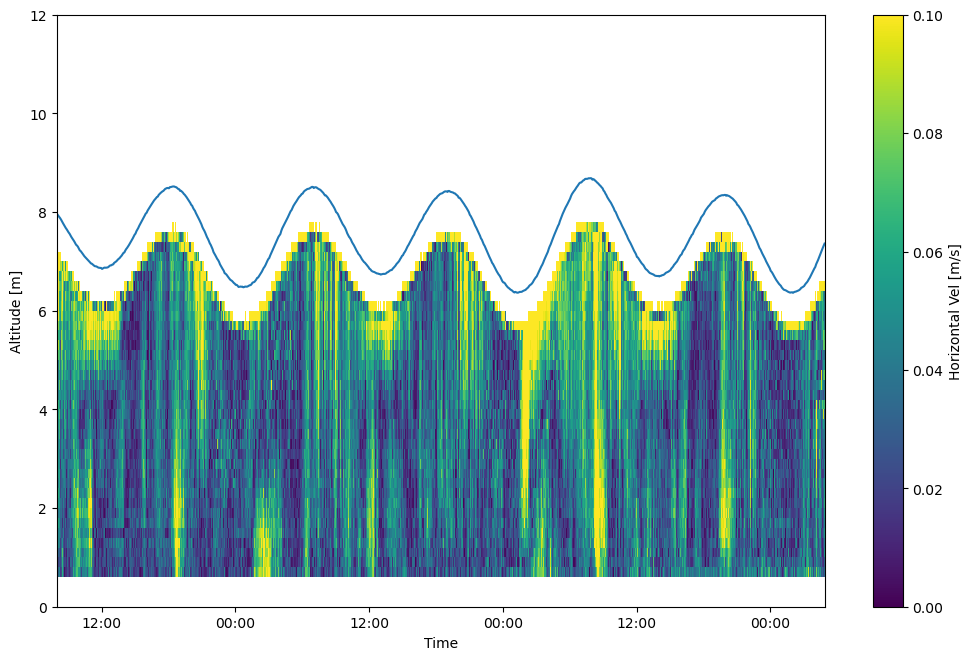

In [388]:
# First look at the magnitude of the flow, by plotting U-mag

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot flow speed
t = dolfyn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg['range'], ds_avg['U_mag'], cmap='viridis', shading='nearest', vmin = 0, vmax = 0.1)
# Plot the water surface
ax.plot(t, ds_avg['depth'])

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Horizontal Vel [m/s]')

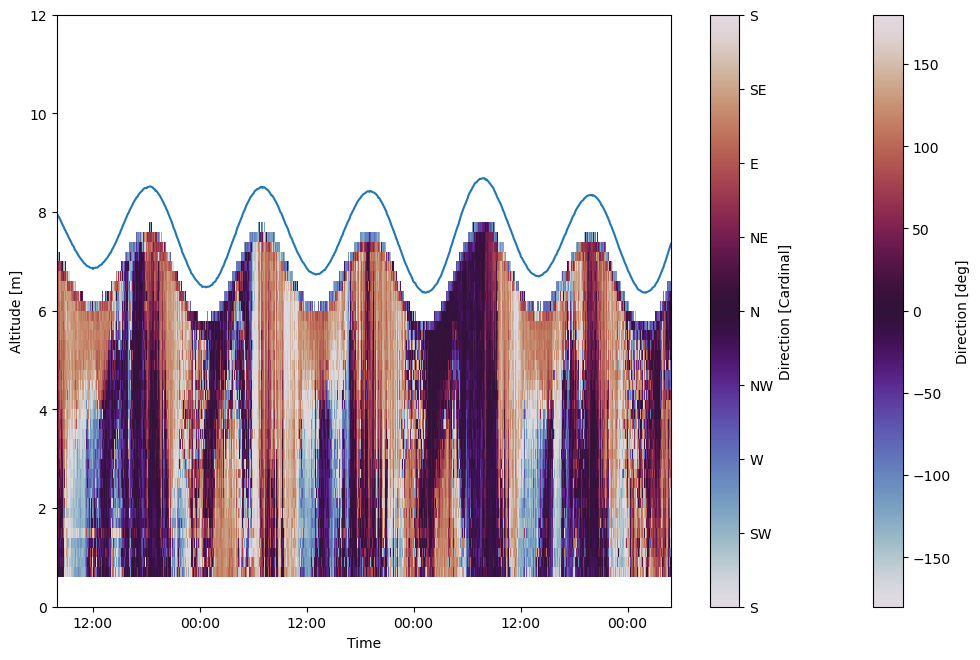

In [390]:
## Next lets look at the direction

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot flow speed
t = dolfyn.time.dt642date(ds_avg.time)
im = plt.pcolormesh(t, ds_avg['range'], ds_avg['U_dir'], cmap='twilight', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg['depth'])

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])

# Primary colorbar in degrees
cbar = plt.colorbar(im, ax=ax, label='Direction [deg]', location='right')

# Secondary colorbar with cardinal directions
def degrees_to_cardinal(degrees):
    cardinal_directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    idx = int((degrees + 22.5) // 45) % 8
    return cardinal_directions[idx]

# Create a list of cardinal directions for the secondary color bar
cbar_ticks_deg = np.linspace(-180, 180, 9)  # Adjust ticks as needed
cbar_ticks_cardinal = [degrees_to_cardinal(deg) for deg in cbar_ticks_deg]

# Add secondary color bar with cardinal directions
cbar2 = plt.colorbar(im, ax=ax, location='right')
cbar2.set_ticks(cbar_ticks_deg)
cbar2.set_ticklabels(cbar_ticks_cardinal)
cbar2.set_label('Direction [Cardinal]')

plt.show()

## More data visulisation

#### Mean velocities across time and depth

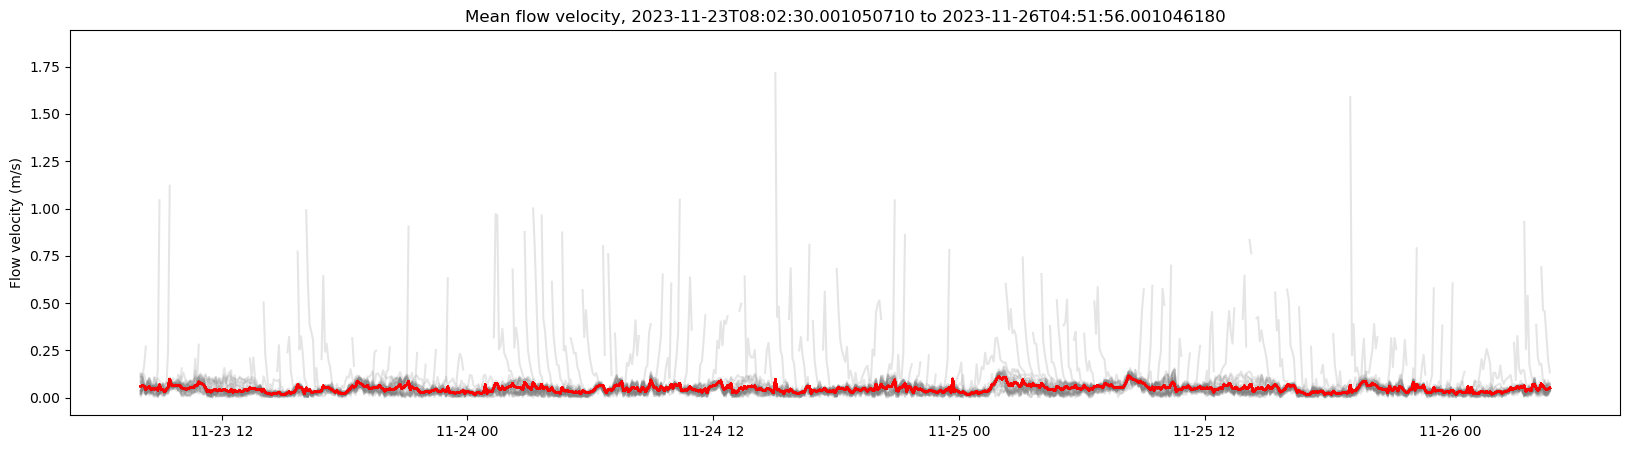

In [393]:


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
mean_U_mag = ds_avg['U_mag'].mean(dim='range')
for depths in range(len(ds_avg['range'])):
    axes.plot(ds_avg['time'], ds_avg['U_mag'][depths], alpha=0.2, color="grey")
    axes.plot(ds_avg['time'], mean_U_mag, alpha=0.9, color="red")
#axes.set_ylim() #set the y limit here
axes.set_ylabel('Flow velocity (m/s)')
plt.title(f'Mean flow velocity, {ds_avg.time[0].values} to {ds_avg.time[-1].values}')
plt.show()


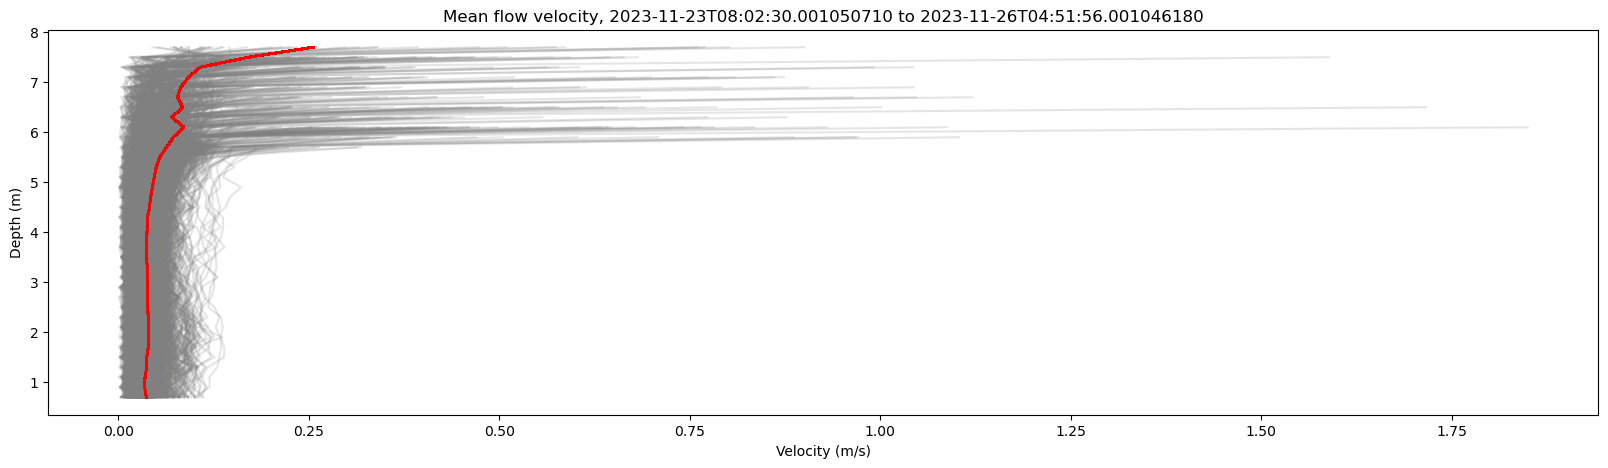

In [395]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
mean_U_mag = ds_avg['U_mag'].mean(dim='time')
for times in range(len(ds_avg['time'])):
    axes.plot( ds_avg['U_mag'][:,times],ds_avg['range'], alpha=0.2, color="grey")
    axes.plot( mean_U_mag, ds_avg['range'], alpha=0.9, color="red")
#axes.set_xlim() #set the x limit here
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Velocity (m/s)')
plt.title(f'Mean flow velocity, {ds_avg.time[0].values} to {ds_avg.time[-1].values}')
plt.show()

### Feather plot of flow magnitude and direction

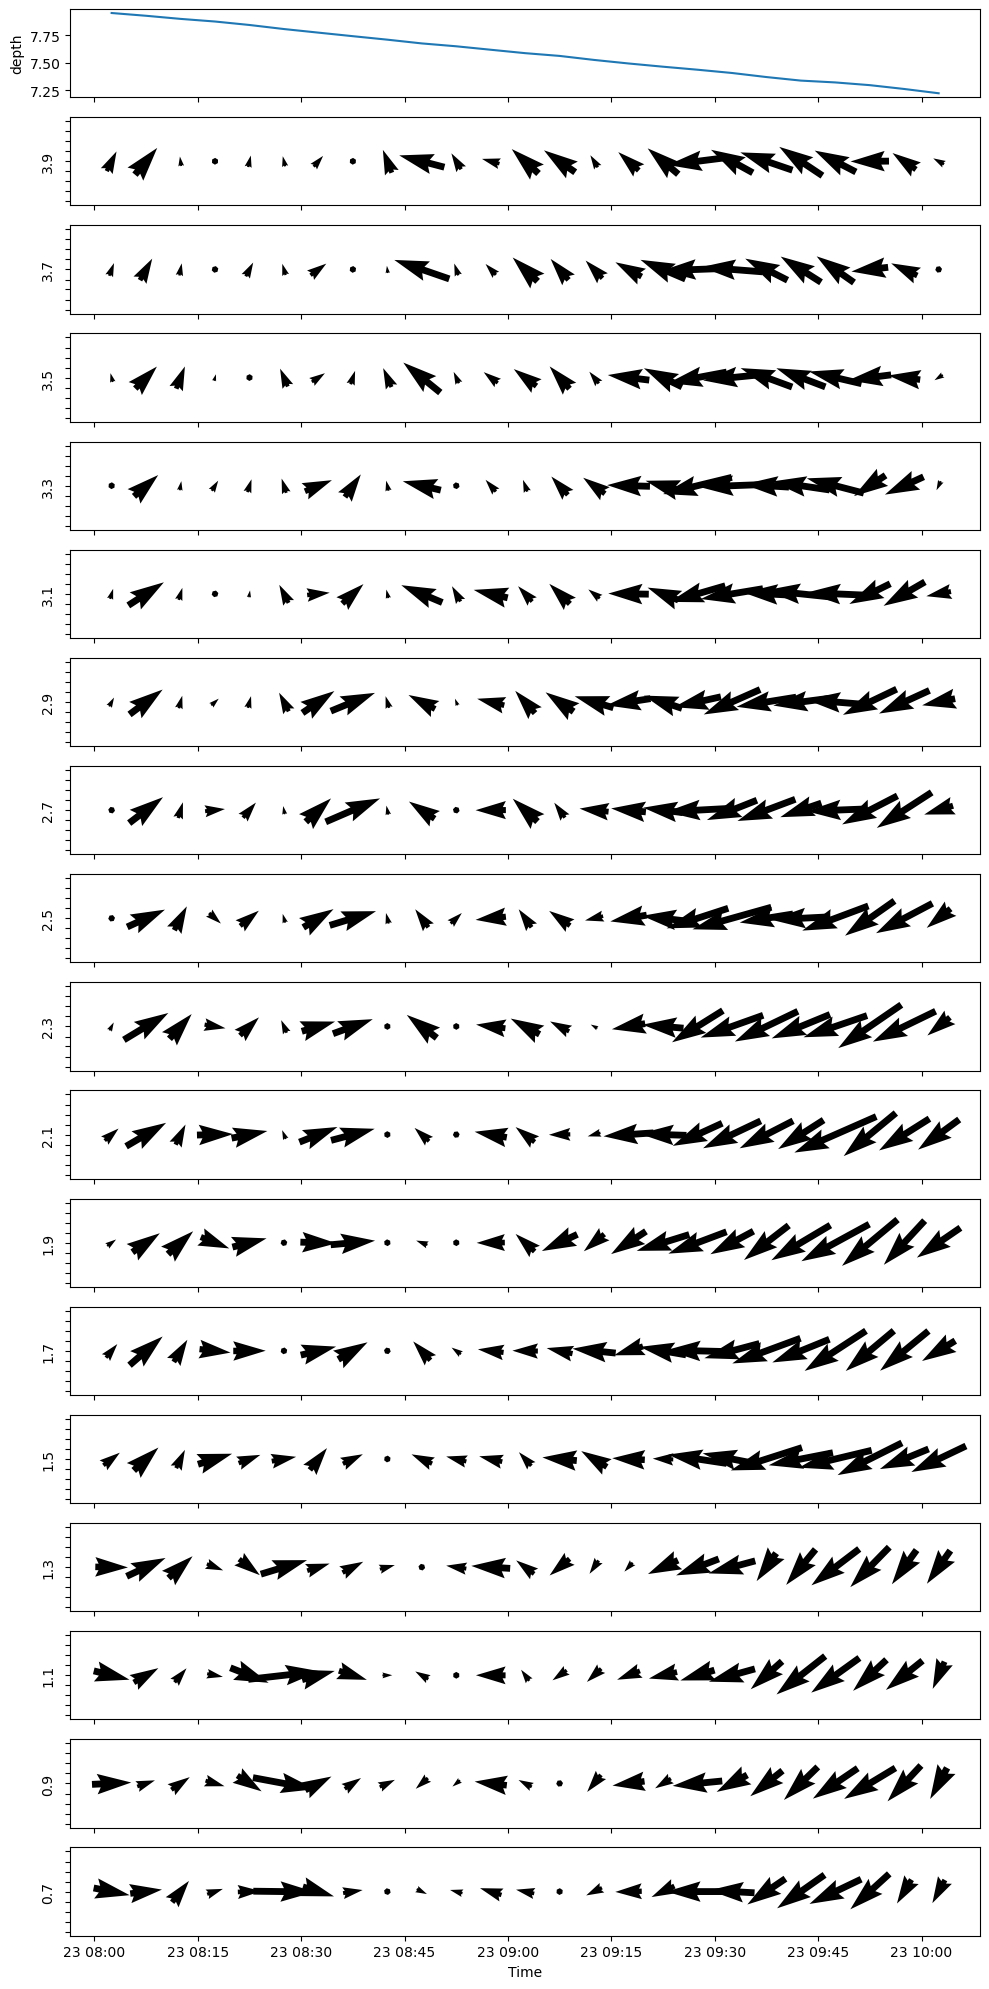

In [398]:
# Limit data to the first 4 hours by selecting times within this range
time_limit = pd.to_timedelta("2h")  # Define 4-hour limit
ds_avg_slice = ds_avg.sel(time=slice(ds_avg['time'][0], ds_avg['time'][0] + time_limit))
ds_avg_slice = ds_avg_slice.sel(range=slice(0, 4))

# Set up subplots: one for pressure, followed by one for each range's quiver plot
fig, axes = plt.subplots(len(ds_avg_slice['range']) + 1, 1, figsize=(10, 20), sharex=True)

# Plot the pressure data on the first axis
axes[0].plot(ds_avg_slice.time, ds_avg_slice['depth'])
axes[0].set_ylabel("depth")

# Loop through each range to create a quiver plot
for i, r in enumerate(reversed(ds_avg_slice['range'])):
    # Extract U_mag and U_Dir for the current range and convert directions
    U_mag = ds_avg_slice['U_mag'].sel(range=r) / 20  # Scale down U_mag
    U_Dir_rad = np.deg2rad(ds_avg_slice['U_dir'].sel(range=r))  # Convert to radians
    
    # Compute U and V components for the quiver arrows
    U = U_mag * np.cos(U_Dir_rad)
    V = U_mag * np.sin(U_Dir_rad)
    
    # Create a quiver plot for the current range
    j = i + 1  # Adjust index to place each plot correctly
    axes[j].quiver(ds_avg_slice['time'], np.zeros_like(ds_avg_slice['time']), U, V, angles='uv', scale_units='xy', scale=0.5, pivot='mid')
    
    # Set y-axis label to show range, formatted to one decimal place
    axes[j].set_ylabel(f"{r.values:.1f}")
    axes[j].set_yticklabels([])  # Hide y-tick labels

# Display the plot with shared x-axis and formatted y-axis labels
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Step 3: Set up data for wave analysis

To do this, we simply make a new pandas dataframe with the relevant data, and save it as a .csv

This way, we can conduct wave analysis in another notebook. 

<Axes: >

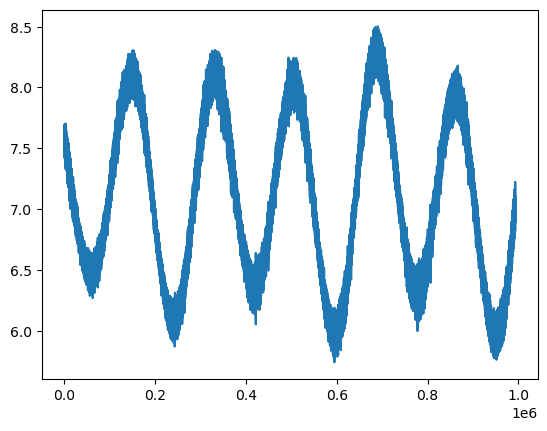

In [302]:
# First, find the relevant data and check it by plotting:
colnames=['index','timestamp','pressure(dbar)','sea_pressure(dbar)',
          'depth(m)','velocity(m/s)'] 


df_select = pd.DataFrame()
df_select['time'] = ds['time']
df_select['pressure'] = ds['pressure'].where(ds['pressure'] != 0)
df_select['depth(m)'] = ds['depth'].where(ds['depth'] !=0.4000000059604645) # This is the NaN value
df_select['pressure'].plot()